In [1]:
# using pylab magic function for convenience
%pylab inline
# pylab to import matplotlib and pandas etc. 
# inline lets you plot figures inline
import numpy as np
# tqdm for the progress bar
from tqdm import trange
import mnist

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the mnist dataset (fails on windows because of filepath)
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if not os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

FileNotFoundError: [Errno 2] No such file or directory: 'tmp\\23278f029ff68f1e993776e500ce06b9'

In [2]:
# workaround for windows
# load the dataset directly through mnist
X_train = mnist.train_images()
Y_train = mnist.train_labels()
X_test = mnist.test_images()
Y_test = mnist.test_labels()

(<matplotlib.image.AxesImage at 0x1b0eebc2550>, 1)

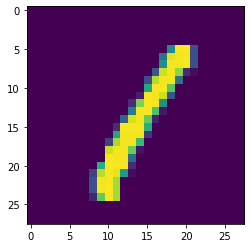

In [3]:
imshow(X_train[3]), Y_train[3]

In [5]:
# first step: recreate everything using pytorch
# conda install pytorch torchvision cpuonly -c pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BeneNet(torch.nn.Module):
  def __init__(self):
    super(BeneNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [4]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
class BeneNet(torch.nn.Module):
  def __init__(self):
    super(BeneNet, self).__init__()
    # fully connected for mnist
    self.l1 = nn.Linear(784, 128, bias = False)
    self.act = nn.ReLU()
    self.l2 = nn.Linear(128, 10, bias = False)
  def forward(self, x):
    x = self.l1(x)
    x = self.act(x)
    x = self.l2(x)
    return x

In [5]:
model = BeneNet()
model(torch.tensor(X_train[0:10].reshape((-1, 28*28))).float())
# model returns an array of class labels for every number. 
# multi class assignment problem =>
# we can use cross entropy loss to train the model

tensor([[ 12.4474,   7.9569,  28.4775,  -1.7730, -15.3082,  23.7786,   5.1677,
          11.8492,  45.7925, -18.6290],
        [ 28.0323,  10.0591,  33.8586,   1.2004,   3.2093,  -8.9328,  32.5369,
          -9.8694,  22.3706,  13.7511],
        [ -8.7645,  18.4892,   0.8786, -21.6998,  -1.9567,  18.3016,   0.2665,
          16.7863,   5.7338,  13.5884],
        [ 17.3182,  19.7516,  32.4924,   4.2767,   1.2999,  -2.6282,  -2.7435,
          15.4265,  -7.5967,  20.8426],
        [-17.8717,  26.1361,  16.1837, -17.9602,  17.3514,  38.4139,  12.3566,
           9.5652, -17.2110,  32.7167],
        [-10.0325,  42.2409,  17.2115,  -5.2528,  31.4294,  26.0037,   7.6951,
          11.1374,  15.7746,  17.8756],
        [-21.3694,   3.1785,  37.1525,  -1.3980,  12.7976,  26.5203,  -0.7220,
          18.7767,  -1.3258,  10.1447],
        [  0.9771,  18.0616,  28.7327, -11.7738,  31.3589,  53.3607, -14.3234,
          13.3738,  19.2631,  -4.6140],
        [-22.0250,  -6.0144,  26.3447,  -2.2308,

In [6]:
X_train.shape[0]

60000

In [7]:
BS = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0)
losses, accuracies = [], []

for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size =(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  optim.zero_grad()
  out = model(X)
  # check for prediction accuracy
  cat = torch.argmax(out, dim = 1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss.backward()
  optim.step()
  print(accuracy)
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))


loss 2.56 accuracy 0.44:   3%|█▌                                                    | 28/1000 [00:00<00:03, 279.31it/s]

tensor(0.0938)
tensor(0.1562)
tensor(0.4062)
tensor(0.)
tensor(0.1875)
tensor(0.3438)
tensor(0.4062)
tensor(0.5312)
tensor(0.5938)
tensor(0.5625)
tensor(0.5625)
tensor(0.5000)
tensor(0.4375)
tensor(0.5312)
tensor(0.5312)
tensor(0.4375)
tensor(0.3750)
tensor(0.5312)
tensor(0.5000)
tensor(0.5625)
tensor(0.4688)
tensor(0.6562)
tensor(0.5938)
tensor(0.6562)
tensor(0.6250)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.6875)
tensor(0.6875)
tensor(0.6562)
tensor(0.4688)
tensor(0.4062)
tensor(0.5938)
tensor(0.6562)
tensor(0.5938)
tensor(0.6250)
tensor(0.7500)
tensor(0.7812)
tensor(0.5625)
tensor(0.5000)
tensor(0.7500)
tensor(0.6562)
tensor(0.6250)
tensor(0.7188)
tensor(0.8125)
tensor(0.5625)
tensor(0.8125)
tensor(0.7812)
tensor(0.7500)
tensor(0.8438)
tensor(0.6562)
tensor(0.7812)
tensor(0.7500)
tensor(0.6875)
tensor(0.7812)
tensor(0.8438)
tensor(0.7500)
tensor(0.7812)
tensor(0.6562)
tensor(0.6875)
tensor(0.4375)


loss 0.45 accuracy 0.81:  10%|█████▎                                               | 100/1000 [00:00<00:02, 313.73it/s]

tensor(0.6562)
tensor(0.8125)
tensor(0.8438)
tensor(0.7500)
tensor(0.7188)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.8438)
tensor(0.7188)
tensor(0.5938)
tensor(0.8125)
tensor(0.7188)
tensor(0.8750)
tensor(0.6875)
tensor(0.8125)
tensor(0.5938)
tensor(0.7188)
tensor(0.7812)
tensor(0.7188)
tensor(0.8125)
tensor(0.9062)
tensor(0.8125)
tensor(0.7188)
tensor(0.6875)
tensor(0.7812)
tensor(0.8125)
tensor(0.7500)
tensor(0.8438)
tensor(0.7500)
tensor(0.7500)
tensor(0.8125)
tensor(0.8438)
tensor(0.7812)
tensor(0.7812)
tensor(0.8125)
tensor(0.7500)
tensor(0.7188)
tensor(0.6875)
tensor(0.7188)
tensor(0.8750)
tensor(0.7500)
tensor(0.8438)
tensor(0.8438)
tensor(0.8438)
tensor(0.7812)
tensor(0.7188)
tensor(0.6875)
tensor(0.8125)
tensor(0.7812)
tensor(0.7188)
tensor(0.8438)
tensor(0.8750)
tensor(0.6562)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.7812)
tensor(0.7812)
tensor(0.8438)
tensor(0.7812)
tensor(0.8438)
tensor(0.7500)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.6

loss 0.47 accuracy 0.81:  18%|█████████▎                                           | 175/1000 [00:00<00:02, 340.96it/s]


tensor(0.7812)
tensor(0.7500)
tensor(0.7812)
tensor(0.8750)
tensor(0.6875)
tensor(0.8750)
tensor(0.6562)
tensor(0.8125)
tensor(0.8438)
tensor(0.8438)
tensor(0.8125)
tensor(0.8125)
tensor(0.8750)
tensor(0.8125)
tensor(0.8125)
tensor(0.7188)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.7500)
tensor(0.6250)
tensor(0.7812)
tensor(0.8125)
tensor(0.8750)
tensor(0.7500)
tensor(0.9062)
tensor(0.7500)
tensor(0.8438)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.7500)
tensor(0.8125)
tensor(0.8750)
tensor(0.7812)
tensor(0.7500)
tensor(0.6875)
tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.7500)
tensor(0.8750)
tensor(0.7500)
tensor(0.7812)
tensor(0.7188)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.7812)
tensor(0.7188)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.

loss 0.46 accuracy 0.88:  25%|█████████████▏                                       | 249/1000 [00:00<00:02, 353.23it/s]


tensor(0.7500)
tensor(0.8438)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.9375)
tensor(0.8750)
tensor(0.7812)
tensor(0.8125)
tensor(0.8125)
tensor(0.7188)
tensor(0.7188)
tensor(0.8125)
tensor(0.9688)
tensor(0.8750)
tensor(0.7500)
tensor(0.6875)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.8438)
tensor(0.8438)
tensor(0.6875)
tensor(0.6562)
tensor(0.8750)
tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.8125)
tensor(0.7812)
tensor(0.9375)
tensor(0.7812)
tensor(0.7188)
tensor(0.9062)
tensor(0.7188)
tensor(0.9062)
tensor(0.8750)
tensor(0.8125)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8438)
tensor(0.8125)
tensor(0.8125)
tensor(0.9062)
tensor(0.7812)
tensor(0.6875)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.8438)
tensor(0.9688)
tensor(0.8750)
tensor(0.

loss 0.20 accuracy 0.91:  33%|█████████████████▎                                   | 326/1000 [00:00<00:01, 368.09it/s]


tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.7812)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.7188)
tensor(0.9375)
tensor(0.7500)
tensor(0.7812)
tensor(0.8125)
tensor(0.7812)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.8438)
tensor(0.7812)
tensor(0.9375)
tensor(0.8438)
tensor(0.8750)
tensor(0.8438)
tensor(0.8125)
tensor(0.9062)
tensor(0.7812)
tensor(0.8438)
tensor(0.7812)
tensor(0.9062)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.9688)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8125)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.7500)
tensor(0.9062)
tensor(0.8125)
tensor(0.8125)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(1.)
tensor(0.7500)
tensor(0.8750)
tensor(0.8750

loss 0.04 accuracy 1.00:  40%|█████████████████████▎                               | 401/1000 [00:01<00:01, 370.22it/s]


tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.8750)
tensor(0.7500)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.8750)
tensor(0.7812)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(1.)
tensor(0.7812)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.7812)
tensor(0.8438)
tensor(1.)
tensor(0.9062)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.8438)
tensor(0.6562)
tensor(0.8750)
tensor(0.7500)
tensor(0.8750)
tensor(0.8438)
tensor(0.9375)
tensor(0.7812)
tensor(0.7812)
tensor(0.8750)
tensor(0.8125)
tensor(0.8750)
tensor(0.7812)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.7812)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(1.)
tensor(0.9062)

loss 0.16 accuracy 0.94:  48%|█████████████████████████▏                           | 476/1000 [00:01<00:01, 365.85it/s]


tensor(0.8438)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.7500)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.8125)
tensor(0.9688)
tensor(0.9062)
tensor(0.8438)
tensor(0.8438)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.7812)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.

loss 0.61 accuracy 0.81:  52%|███████████████████████████▎                         | 515/1000 [00:01<00:01, 369.95it/s]


tensor(0.8438)
tensor(0.8125)
tensor(0.9688)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(1.)
tensor(0.8438)
tensor(0.8125)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.7812)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9688)
tensor(1.)
tensor(0.9688)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.9688)
tensor(0.8125)
tensor(0.8438)
tensor(0.8438)
tensor(0.9375)
tensor(0.8125)
tensor(0.9062)
tensor(0.8125)
tensor(0.9062)
tensor(1.)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)

loss 0.10 accuracy 0.97:  59%|███████████████████████████████▎                     | 590/1000 [00:01<00:01, 372.16it/s]


tensor(0.9062)
tensor(0.8125)
tensor(0.9688)
tensor(0.9375)
tensor(1.)
tensor(0.9688)
tensor(0.8438)
tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.7188)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.8125)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(1.)
tensor(0.9688)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(0.8125)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.8125)
tensor(0.8125)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.8125)
tensor(0.9688)
tensor(0.9688)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(1.)
tensor(0.9375)
tensor(0.9

loss 0.11 accuracy 0.97:  67%|███████████████████████████████████▍                 | 669/1000 [00:01<00:00, 373.96it/s]

tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(1.)
tensor(0.9688)
tensor(0.9062)
tensor(1.)
tensor(0.8125)
tensor(0.8125)
tensor(0.9688)
tensor(0.9375)
tensor(0.8438)
tensor(0.8125)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.7500)
tensor(0.8438)
tensor(0.9375)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.8125)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(1.)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(1.)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.8125)
tensor(0.9375)
tensor(0.9062)
tensor(0.8125)
tensor(0.9375)
tensor(0.8125)
tensor(1.)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tens

loss 0.52 accuracy 0.84:  75%|███████████████████████████████████████▌             | 746/1000 [00:02<00:00, 378.11it/s]

tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.8750)
tensor(0.8125)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.8438)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(1.)
tensor(1.)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.8125)
tensor(0.9688)
tensor(0.8750)
tensor(0.8750)
tensor(0.8750)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.7500)
tensor(0.9688)
tensor(0.9062)
tensor(0.8438)
tensor(1.)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.8438)
tensor(0.84

loss 0.40 accuracy 0.88:  82%|███████████████████████████████████████████▌         | 822/1000 [00:02<00:00, 370.19it/s]

tensor(0.8438)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.9688)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.9688)
tensor(0.9688)
tensor(0.9688)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.8125)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.7500)
tensor(0.9688)
tensor(0.9062)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.7812)
tensor(0.9688)
tensor(0.9688)
tensor(0.8750)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)

loss 0.45 accuracy 0.91:  90%|███████████████████████████████████████████████▌     | 898/1000 [00:02<00:00, 374.15it/s]

tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9062)
tensor(0.8750)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9688)
tensor(0.8750)
tensor(0.8438)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9375)
tensor(1.)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(1.)
tensor(0.9375)
tensor(1.)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(1.)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.93

loss 0.12 accuracy 0.97:  94%|█████████████████████████████████████████████████▌   | 936/1000 [00:02<00:00, 370.22it/s]


tensor(0.8125)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(1.)
tensor(0.8438)
tensor(0.9688)
tensor(1.)
tensor(1.)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.9375)
tensor(0.9375)
tensor(0.8750)
tensor(0.9062)
tensor(0.8438)
tensor(0.9688)
tensor(0.8438)
tensor(0.8125)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.9375)
tensor(0.8750)
tensor(1.)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
tensor(0.9688)
tensor(0.7500)
tensor(0.9062)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.7812)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.8125)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.9688)
tensor(0.9688)
tensor(0.8438)
tensor(0.8750)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)

loss 0.08 accuracy 1.00: 100%|████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.85it/s]


tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(0.9375)
tensor(0.8750)
tensor(0.9375)
tensor(0.9688)
tensor(0.8750)
tensor(0.9688)
tensor(0.9375)
tensor(1.)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.9062)
tensor(0.8750)
tensor(0.9062)
tensor(0.7812)
tensor(0.9375)
tensor(0.9688)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.9375)
tensor(0.9688)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8438)
tensor(0.9688)
tensor(0.9062)
tensor(0.9375)
tensor(0.9062)
tensor(1.)


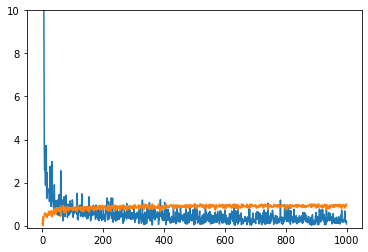

In [8]:
plt.ylim(-0.1, 10)
plot(losses)
plot(accuracies)


In [9]:
# evaluate performance
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim = 1).numpy()
(Y_test == Y_test_preds).mean()

0.9143

In [15]:
# trying to recreate everything from scratch #
# initialize the network
l1 = np.zeros((784, 128), dtype = np.float32)
l2 = np.zeros((128, 10), dtype = np.float32)
l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 1859463639648, 1859463639568)

In [18]:
# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [22]:
# numpy forward pass 
# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x

def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

numpy_eval()
# same result as pytorch!

0.9143

In [23]:
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)

In [ ]:
# lets use the loss as a measure of uncertainty
samp = 1
-Y_test_preds_out[samp, Y_test[samp]] + np.log(np.exp(Y_test_preds_out[samp]).sum())


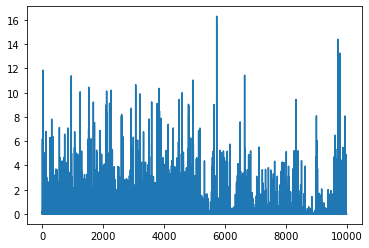

In [34]:
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis = 1))
ret
plot(ret)

In [36]:
np.argmax(ret)

5734

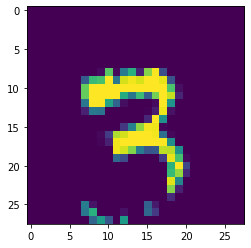

In [39]:
# lets plot the best and worst samples!
imshow(X_test[np.argmax(ret)])

In [43]:
sorted(list(zip(ret, range(ret.shape[0]))), reverse = True)
sorted(list(zip(ret, range(ret.shape[0]))), reverse = False)

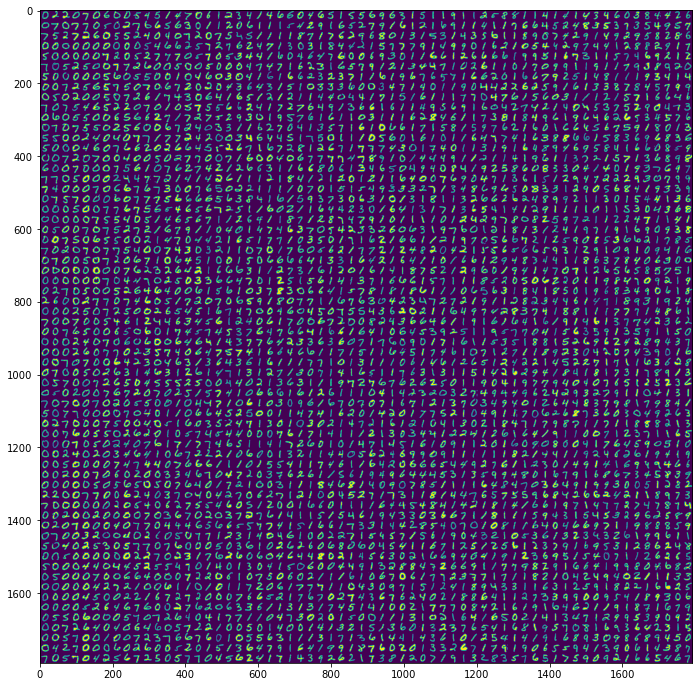

In [66]:
G = 64
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse = False)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
figsize(12,12)
imshow(np.concatenate(X_bad.reshape((G, 28*G, 28)), axis = 1))

(tensor(1.),
 tensor([[ 4.5408e-09,  6.5068e-10,  9.1954e-06,  1.7366e-06,  3.9300e-10,
           6.0241e-08,  6.4302e-13, -1.1325e-05,  7.0615e-10,  3.5861e-07]]))

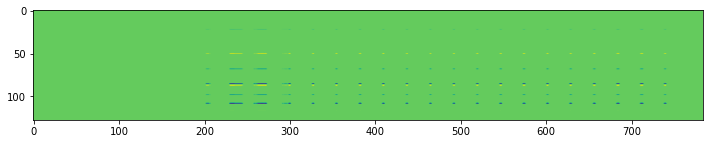

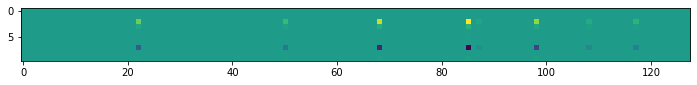

In [72]:
# gradients
model.zero_grad()
out = model(torch.tensor(X_test[0:1].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[0:1]).long())
loss.retain_grad()
loss.backward()

imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

loss.grad, out.grad

[5734,
 9716,
 9779,
 33,
 6651,
 956,
 4956,
 3073,
 1530,
 3838,
 2266,
 2118,
 1247,
 4601,
 3206,
 8339]